In [6]:
import pandas as pd
df = pd.read_csv('../dataset/DBPEDIA_train.csv')
document_list = df['text'].to_numpy().astype('str')
document_list.dtype

dtype('<U3944')

In [7]:
# # Tokenizeing documents
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# encoded_list = []

# for i, doc in enumerate(document_list):
#     encoded = tokenizer.encode_plus(doc, add_special_tokens=True, max_length=512)
#     encoded_list.append(encoded)

In [8]:
# df['text'] = encoded_list

In [9]:
# encoding topics to create the adjacency matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

labelEncoder = LabelEncoder()
topics = np.concatenate((df['l1'].unique(), df['l2'].unique(), df['l3'].unique()))
labelEncoder.fit(topics)

def encode_topic(topic):
    print(type(topic))
    return labelEncoder.transform(topic)

df['l1_encoded'] = labelEncoder.transform(df['l1'])
df['l2_encoded'] = labelEncoder.transform(df['l2'])
df['l3_encoded'] = labelEncoder.transform(df['l3'])


In [10]:
graph_dict = {}

for i, row in df.iterrows():
    l1 = row['l1_encoded']
    l2 = row['l2_encoded']
    l3 = row['l3_encoded']

    if l1 not in graph_dict:
        graph_dict[l1] = {}
    if l2 not in graph_dict[l1]:
        graph_dict[l1][l2] = {} 

    graph_dict[l1][l2][l3] = 1

In [11]:
# creating adjacency matrix
adj_matrix = np.zeros((len(topics), len(topics)))
square_numeric_dict = {'source': [], 'target': []}
for i, df_row in df.iterrows():
    l1 = df_row['l1_encoded']
    l2 = df_row['l2_encoded']
    l3 = df_row['l3_encoded']

    adj_matrix[l1, l2] = 1
    adj_matrix[l2, l3] = 1

for i, row in enumerate(adj_matrix):
    for j, value in enumerate(row):
        if value == 0:
            continue
        square_numeric_dict['source'].append(i)
        square_numeric_dict['target'].append(j)

square_numeric_edges = pd.DataFrame(square_numeric_dict)

In [12]:
# creating node features
x = np.arange(298)
x = labelEncoder.inverse_transform(x)
feature_array = x.reshape(298, -1)

In [13]:
# loading GloVe model to get topic word embeddings
# from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
import torch
import torchtext

glove = torchtext.vocab.GloVe(name="6B", dim=50)

In [14]:
# Creating "ego-graphs" (each node is seperated into a graph with itself, parent, and siblings)
# The base node (so the node itself) will be masked, aka. have a [MASK] embedding
# The sibling nodes need to have a negative relationship with the base node (so negative value in adjacency matrix?)
from spektral.data import Graph
import numpy as np
import re
def create_ego_graph(l1_topic, l2_topic, l3_topic, graph_dict):
    if l3_topic != None:
        siblings_list = list(graph_dict[l1_topic][l2_topic].keys())
        siblings_list.remove(l3_topic)
        base = l3_topic
        parent = l2_topic
        grandparent = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        all_nodes_list.append(parent)
        all_nodes_list.append(grandparent)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]
        encoded_parent = node_label_encoder.transform([parent])[0]
        encoded_grandparent = node_label_encoder.transform([grandparent])[0]

        adj_matrix[encoded_base][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_base] = 1

        adj_matrix[encoded_grandparent][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_grandparent] = 1

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1
        
    elif l2_topic != None:
        siblings_list = list(graph_dict[l1_topic].keys())
        siblings_list.remove(l2_topic)
        base = l2_topic
        parent = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        all_nodes_list.append(parent)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]
        encoded_parent = node_label_encoder.transform([parent])[0]

        adj_matrix[encoded_base][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_base] = 1

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1
    
    elif l1_topic != None:
        siblings_list = list(graph_dict.keys())
        siblings_list.remove(l1_topic)
        base = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1

    ego_features = np.zeros((n_nodes, 50))
    y = [0, 1] if l1_topic != 3 else [1, 0]
    encoded_nodes_list = node_label_encoder.transform(all_nodes_list)

    for i, node in enumerate(all_nodes_list):
        feature = feature_array[node]
        split_words_list = re.sub( r"([A-Z])", r" \1", feature[0]).split()
        n_words = len(split_words_list)
        embedding_avg = np.array([glove[word.lower()].numpy() for word in split_words_list]).sum(axis=0)/n_words
        
        # Masking base node, setting the embedding to all 0's
        if (node == base):
            embedding_avg = glove['MASK']

        ego_features[encoded_nodes_list[i]] = embedding_avg

    return Graph(a=adj_matrix, x=ego_features, y=y)

graph_list = []

for l1_topic in graph_dict:
    for l2_topic in graph_dict[l1_topic]:
        for l3_topic in graph_dict[l1_topic][l2_topic]:
            graph_list.append(create_ego_graph(l1_topic, l2_topic, l3_topic, graph_dict))
        graph_list.append(create_ego_graph(l1_topic, l2_topic, None, graph_dict))
    graph_list.append(create_ego_graph(l1_topic, None, None, graph_dict))

graph_list = np.array(graph_list)

In [15]:
from spektral.data import Dataset

class MyDataset(Dataset):
    """
    """
    def __init__(self, graph_list: list[Graph], **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def read(self):
        # We must return a list of Graph objects
        num_l =  np.random.permutation(len(self.graph_list))
        return [self.graph_list[i] for i in num_l]
    
dataset = MyDataset(graph_list)

In [16]:
from spektral.data import DisjointLoader, BatchLoader
from transformers import BertTokenizer

learning_rate = 1e-3  # Learning rate
epochs = 20  # Number of training epochs
batch_size = 32  # Batch size

# Train/test split
np.random.shuffle(dataset)
split = int(0.6 * len(dataset))
data_tr, data_te = dataset[:split], dataset[split:]

loader_tr = DisjointLoader(data_tr, batch_size=3, epochs=epochs)
loader_te = DisjointLoader(data_te, batch_size=3,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

C:\Users\saif8\AppData\Local\Temp\ipykernel_55516\7052471.py:9: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset)


In [17]:
# Code from the tensorflow_ranking source code
# Source: https://github.com/tensorflow/ranking/blob/v0.5.2/tensorflow_ranking/python/keras/layers.py#L806-L891
# Need to modify code since the original implementation only takes two embeddings of the SAME shape
# For this case however, the topic embedding and the BERT embedding have two different shapes (50 x 768)
import tensorflow as tf
import math

class Bilinear(tf.keras.layers.Layer):
  """A Keras Layer makes bilinear interaction of two vectors.
  This Keras Layer implements the bilinear interaction of two vectors of
  embedding dimensions. The bilinear, linear and scalar parameters of the
  interaction are trainable.
  The bilinear interaction are used in the work "Revisiting two tower models
  for unbiased learning to rank" by Yan et al, see
  https://research.google/pubs/pub51296/.
  In this work, the bilinear interaction appears to be helpful in model the
  complex interaction between position and relevance in unbiased LTR.
  """

  def __init__(self, embedding1_dim: int, embedding2_dim: int, output_dim: int, **kwargs: dict[any,
                                                                         any]):
    """Initializer.
    Args:
      embedding_dim: An integer that indicates the embedding dimension of the
        interacting vectors.
      output_dim: An integer that indicates the output dimension of the layer.
      **kwargs: A dict of keyword arguments for the tf.keras.layers.Layer.
    """
    super().__init__(**kwargs)
    self._embedding1_dim = embedding1_dim
    self._embedding2_dim = embedding2_dim
    self._output_dim = output_dim

  def build(self, input_shape: tf.TensorShape):
    """See tf.keras.layers.Layer."""
    # Create a trainable weight variable for this layer.
    self._bilinear_weight = self.add_weight(
        name='bilinear_term',
        shape=(self._embedding1_dim, self._embedding2_dim, self._output_dim),
        initializer=tf.keras.initializers.RandomNormal(stddev=1. / self._embedding1_dim),
        trainable=True)
    self._linear_weight_1 = self.add_weight(
        name='linear_term_1',
        shape=(self._embedding2_dim, self._output_dim),
        initializer=tf.keras.initializers.RandomNormal(
            stddev=1. / math.sqrt(self._embedding1_dim)),
        trainable=True)
    self._linear_weight_2 = self.add_weight(
        name='linear_term_2',
        shape=(self._embedding2_dim, self._output_dim),
        initializer=tf.keras.initializers.RandomNormal(
            stddev=1. / math.sqrt(self._embedding1_dim)),
        trainable=True)
    self._bias = self.add_weight(
        name='const_term',
        shape=(self._output_dim),
        initializer=tf.keras.initializers.Zeros(),
        trainable=True)
    super().build(input_shape)

  def call(self, inputs: tuple[tf.Tensor]) -> tf.Tensor:
    """Computes bilinear interaction between two vector tensors.
    Args:
      inputs: A pair of tensors of the same shape [batch_size, embedding_dim].
    Returns:
      A tensor, of shape [batch_size, output_dim], computed by the bilinear
      interaction.
    """
    # Input of the function must be a list of two tensors.
    vec_1, vec_2 = inputs
    return tf.einsum(
        'bi,ijk,bj->bk', vec_1, self._bilinear_weight, vec_2) + tf.einsum(
            'bi,ik->bk', vec_1, self._linear_weight_1) + tf.einsum(
                'bi,ik->bk', vec_2, self._linear_weight_2) + self._bias

  def compute_output_shape(self, input_shape: tf.TensorShape) -> tuple[int]:
    """See tf.keras.layers.Layer."""
    return (input_shape[0], self._output_dim)

  def get_config(self) -> dict[str, any]:
    """See tf.keras.layers.Layer."""
    config = super().get_config()
    config.update({
        'embedding1_dim': self._embedding1_dim,
        'embedding2_dim': self._embedding2_dim,
        'output_dim': self._output_dim
    })
    return config

In [19]:
################################################################################
# Build model
################################################################################
from tensorflow import int64
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from spektral.layers import GCNConv, GlobalAvgPool, GraphMasking
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
import tensorflow as tf
from transformers import TFBertModel
import keras_nlp
# model = Net()
optimizer = Adam(learning_rate)
loss_fn = CategoricalCrossentropy()

# Custom training loop
class ModelWithNCE(Model):
    @tf.function(experimental_relax_shapes=True)
    def train_step(self, data):
        # print(data)
        inputs, target = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(target, predictions) + sum(self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(target, predictions)
        return {m.name: m.result() for m in self.metrics}

# GNNs (Topic Encoder)
n_out = dataset.n_labels
        
X_in = Input(shape=(dataset.n_node_features))
A_in = Input(shape=(None,), sparse=True)
I_in = Input(shape=(), dtype=int64)

X = GCNConv(32, activation='relu')([X_in, A_in])
X = GCNConv(32, activation='relu')([X, A_in])
X = GlobalAvgPool()([X, I_in])

# BERT Embedding (Document Encoder)
max_len = 32
max_seq_length = max_len
encoder = TFBertModel.from_pretrained('bert-base-uncased')

vocab_size = tokenizer.vocab_size

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
embedding = encoder(input_ids)[0]

# Transformer Decoders (Phrase Generator)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(embedding)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(embedding, transformer_decoder)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(embedding, transformer_decoder)

# Transformer Output
out2 = Dense(vocab_size)(transformer_decoder)

# Shared Bilinear layer (Similarity Predictor)
shared_bilinear = Bilinear(32, 768, 1)
out = shared_bilinear([X, X_in])

# Outputs
# out = Dense(n_out, activation='softmax')(X)

model = ModelWithNCE(inputs=[X_in, A_in, I_in, input_ids], outputs=[out, out2])


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


ValueError: Exception encountered when calling layer "bilinear" (type Bilinear).

in user code:

    File "C:\Users\saif8\AppData\Local\Temp\ipykernel_55516\2068209214.py", line 74, in call  *
        'bi,ik->bk', vec_2, self._linear_weight_2) + self._bias

    ValueError: Dimensions must be equal, but are 50 and 768 for '{{node bilinear/einsum/Einsum}} = Einsum[N=2, T=DT_FLOAT, equation="bj,ijk->bik"](Placeholder_1, bilinear/einsum/Einsum/ReadVariableOp)' with input shapes: [?,50], [32,768,1].


Call arguments received by layer "bilinear" (type Bilinear):
  • inputs=['tf.Tensor(shape=(None, 32), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)']

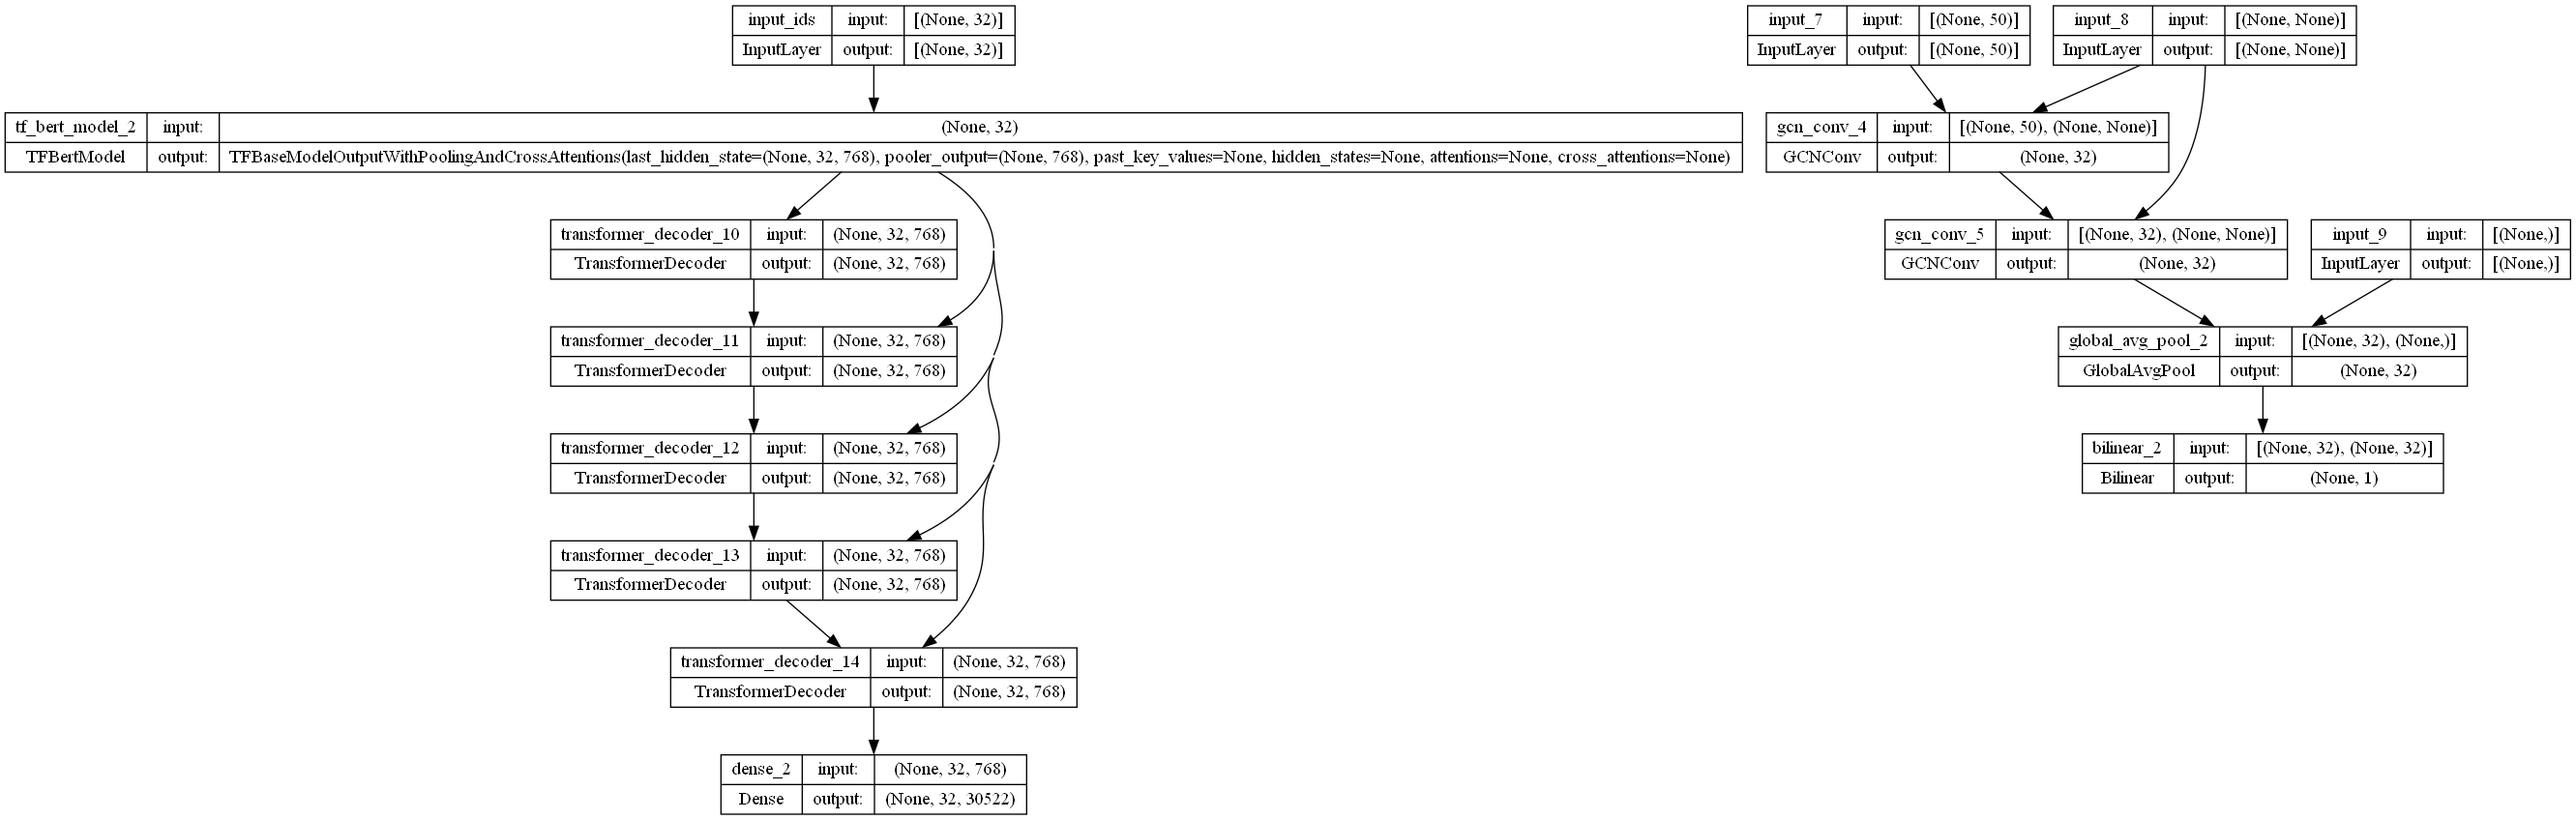

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'], run_eagerly=True)
model.summary()
# model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=epochs)

Model: "model_with_nce_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]']              
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 32,                                                
                                768),                                                             
                                 pooler_output=(Non                                

In [78]:
################################################################################
# Evaluate model
################################################################################
print("Testing model")
loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(loss))

Testing model
40/40 [==============================] - 1s 14ms/step - loss: 0.0955 - accuracy: 0.9917
Done. Test loss: [0.09553246200084686, 0.9916666746139526]


In [1]:
################################################################################
# Build model
################################################################################
from tensorflow import int64
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import tensorflow_ranking

from spektral.layers import GCNConv, GlobalAvgPool, GraphMasking

# n_out = dataset.n_labels

X_in = Input(shape=(50))
A_in = Input(shape=(None,), sparse=True)
I_in = Input(shape=(), dtype=int64)

X = GCNConv(32, activation='relu')([X_in, A_in])
X = GCNConv(32, activation='relu')([X, A_in])
X = GlobalAvgPool()([X, I_in])

shared_bilinear = tensorflow_ranking.keras.layers.Bilinear(32, 32)
X_1 = shared_bilinear([X, X])
X = shared_bilinear([X, X], training=False)

out = Dense(2, activation='softmax')(X)

model = Model(inputs=[X_in, A_in, I_in], outputs=out)


In [2]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
